# Parabolic Mirror
Define a phase mask to represent a parabolic mirror, then propagate the field.

In [1]:
from diffractio import um, nm, mm, np, degrees
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
%matplotlib inline

from numpy import *
from matplotlib import pyplot as plt

import os, sys
sys.path.append(os.path.join('.',".."))

# local imports
from field_funcs import *
from simfuncs import soln_to_csv, soln_from_csv

number of processors: 8
total memory        : 15.6 Gb
available memory    : 50 %
max frequency       : 2995 GHz
screeninfo not imported.
cv2 not imported. Function send_image_screen cannot be used


In [2]:
NA_to_waist = lambda NA: lmbda/(pi*tan(arcsin(NA)))

width = 9*mm
pts = 2**12
x0 = np.linspace(-width/2, width/2, pts)
y0 = np.linspace(-width/2, width/2, pts)
lmbda = 0.852 * um
k = 2*pi/lmbda

# get Gaussian waist after light from SM fiber collimated by lens f
f = 30*mm
wf = NA_to_waist(0.13)
w0 = lmbda*f/(pi*wf)

In [3]:
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=lmbda)

u0.gauss_beam(r0=(0, 0), w0=w0)
# u0.draw(kind='intensity') #, filename='xy_source.png')

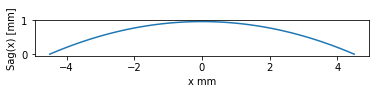

In [4]:
## phase mask from parabolic mirror

r = 10.5*mm # best fit sphere radius of curvature
focus = r/2
semi_dia = 4.5*mm # mechanical radius

rho_pts = linspace(-semi_dia,semi_dia,100)
sag = lambda rho: r*(1-0.5*(rho/r)**2)
min_sag = min(sag(rho_pts))
sag = lambda rho: r*(1-0.5*(rho/r)**2) - min_sag

fig, ax = plt.subplots()
ax.plot(rho_pts/mm, sag(rho_pts)/mm)
ax.set_xlabel("x mm")
ax.set_ylabel("Sag(x) [mm]")
ax.set_aspect(1)

x0pts, midpt, xx, yy = get_meshgrid(width/2, pts)
rr = sqrt(xx**2 + yy**2)
aper = circ_mask(rr, semi_dia).astype(complex)
phase = k*sag(rr)
# the complex mask
mask = aper + 1j*aper*angle(exp(-1j*phase))

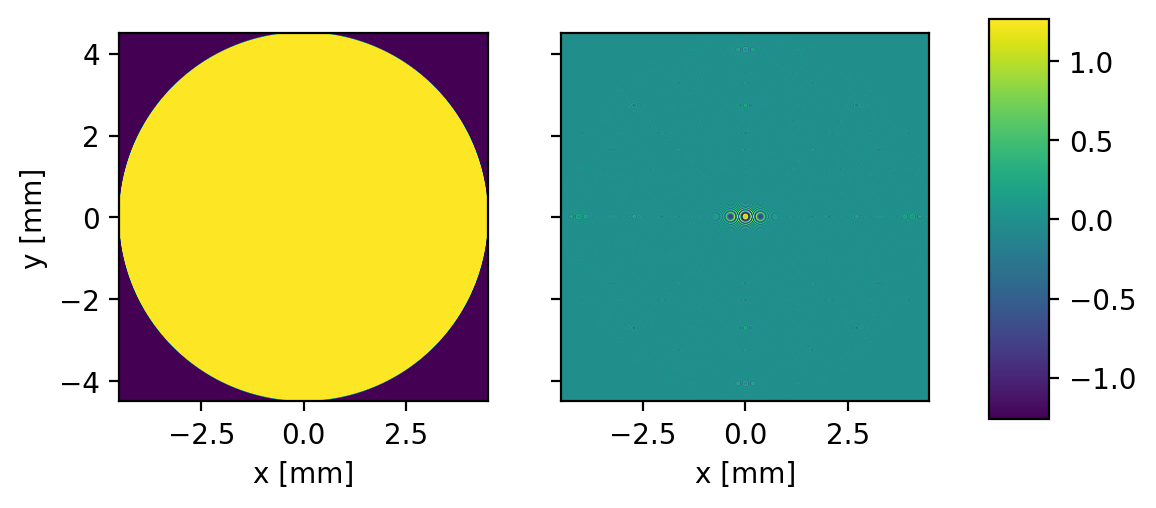

In [66]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True,dpi=200)
ax1,ax2 = axes
w = width/mm/2
ax1.imshow(abs(aper), extent=[-w,w,-w,w])
im = ax2.imshow(angle(mask), extent=[-w,w,-w,w])
for ax in axes:
    ax.set_aspect(1)
    ax.set_xlabel("x [mm]")
ax1.set_ylabel("y [mm]")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)

# plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
# cbar = fig.colorbar(cax,fraction=0.15, shrink=.75, aspect=15,
#     pad=0.05, anchor=(0.5, 0.5), panchor=(1.0, 0.5))

In [5]:
t0 = Scalar_mask_XY(x=x0, y=y0, wavelength=lmbda)
t0.u = mask # the complex mask

# apply the mask, calculate the new field
u1 = u0 * t0
time0 = time()
df = 0
print(f"defocus {df/um}um")
u2 = u1.RS(z=focus+df, new_field=True)
print(f"computed in {time() - time0}s")

defocus 0.0um
computed in 120.67542862892151s


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x2a593421bb0>)

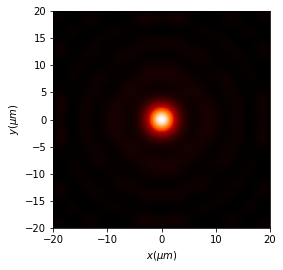

In [9]:
nw = 20 * um
uresamp = u2.cut_resample(
  x_limits=(-nw, nw),
  y_limits=(-nw, nw),
  num_points=[1024, 1024],
  new_field=True)
uresamp.draw(kind='intensity')

defocus -0.04um
computed in 42.17668318748474s
defocus -0.02um
computed in 36.206329107284546s
defocus -0.01um
computed in 35.34398102760315s
defocus 0.0um
computed in 33.063435792922974s
defocus 0.01um
computed in 35.65135955810547s
defocus 0.02um
computed in 36.31928277015686s
defocus 0.04um
computed in 34.59350514411926s


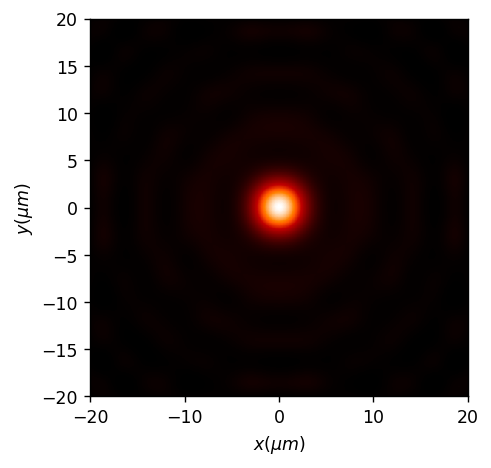

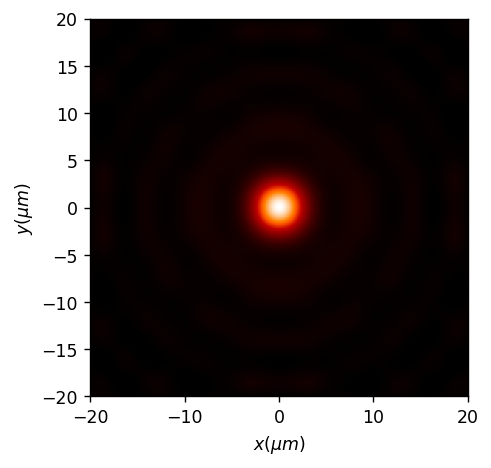

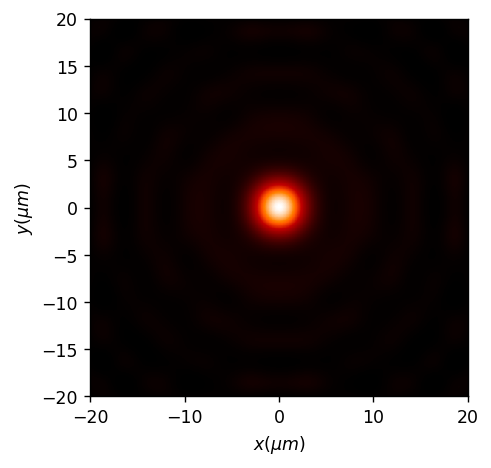

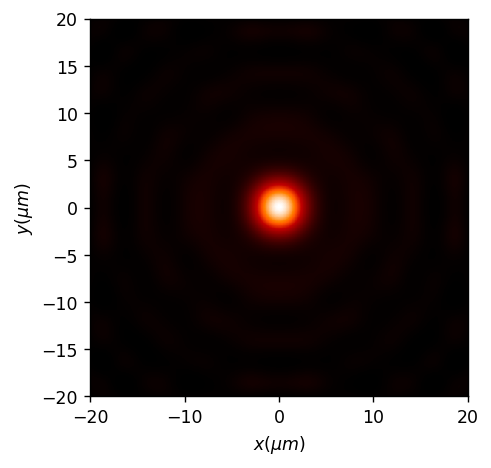

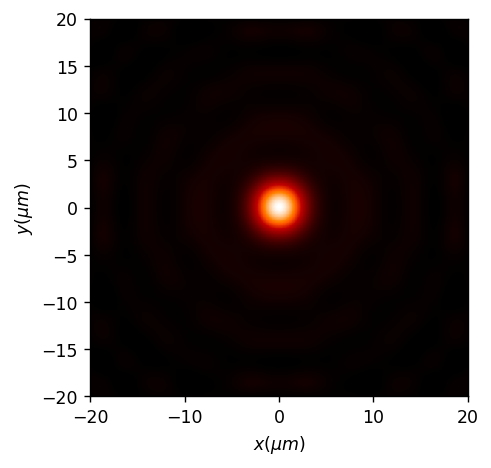

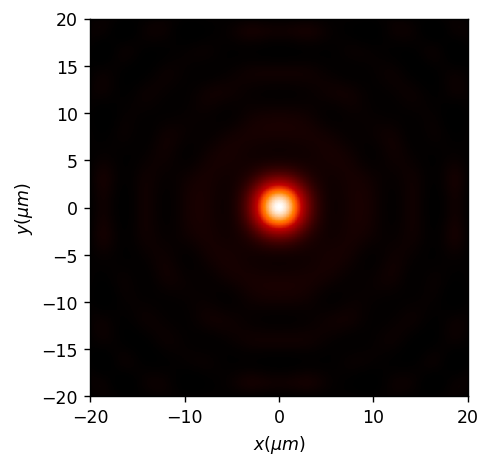

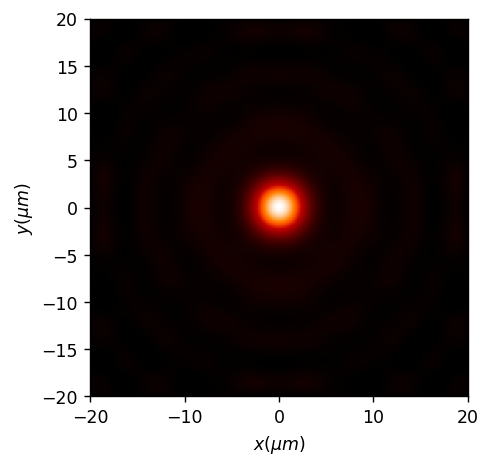

In [47]:
t0 = Scalar_mask_XY(x=x0, y=y0, wavelength=lmbda)
t0.u = mask # the complex mask

# t0.draw(kind='phase',has_colorbar=True) #filename='xy_mask.png')
# t0.draw(kind='amplitude',has_colorbar=True) #filename='xy_mask.png')

# apply the mask, calculate the new field
u1 = u0 * t0
for df in [-0.04*um, -0.02*um, -0.01*um, 0, 0.01*um, 0.02*um, 0.04*um]:
    time0 = time()
    print(f"defocus {df/um}um")
    u2 = u1.RS(z=focus+df, new_field=True)
    print(f"computed in {time() - time0}s")
    nw = 20 * um
    u2.cut_resample(
      x_limits=(-nw, nw),
      y_limits=(-nw, nw),
      num_points=[1024, 1024],
      new_field=False)
    u2.draw(kind='intensity')

wrote data to parabolic_mir_dia9mm_roc10pt5_spot_vs_gaussian.csv


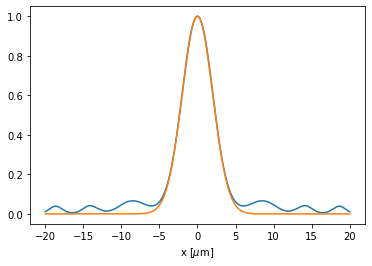

In [14]:
slicelen = len(uresamp.u[0,:])
slicepts = uresamp.u[slicelen//2,:]
xpts = linspace(-nw,nw,slicelen)
plt.plot(xpts, abs(slicepts)**2/max(abs(slicepts)**2))
plt.plot(xpts, exp(-2*(xpts/(4*um))**2))
plt.xlabel(r"x [$\mu$m]")

data = [xpts, abs(slicepts)**2/max(abs(slicepts)**2), exp(-2*(xpts/(4*um))**2)]
labels = ['xpts', 'focal intensity', 'w0=4 um Gaussian']

# fname = "parabolic_mir_dia9mm_roc10pt5_spot_vs_gaussian.csv"
# soln_to_csv(fname, data, labels, metastr=None)

## Parabolic mirror with thru-hole

In [86]:
2**13

8192

In [2]:
NA_to_waist = lambda NA: lmbda/(pi*tan(arcsin(NA)))

width = 9*mm
pts = 2**13
x0 = np.linspace(-width/2, width/2, pts)
y0 = np.linspace(-width/2, width/2, pts)
lmbda = 0.852 * um
k = 2*pi/lmbda

# get Gaussian waist after light from SM fiber collimated by lens f
f = 30*mm
wf = NA_to_waist(0.13)
w0 = lmbda*f/(pi*wf)

In [4]:
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=lmbda)

u0.gauss_beam(r0=(0, 0), w0=w0)
# u0.draw(kind='intensity') #, filename='xy_source.png')

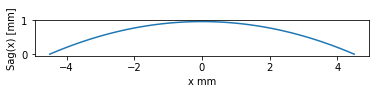

In [5]:
## phase mask from parabolic mirror

r = 10.5*mm # best fit sphere radius of curvature
focus = r/2
semi_dia = 4.5*mm # mechanical radius of mirror
hole_semi_dia = .5*mm

rho_pts = linspace(-semi_dia,semi_dia,100)
sag = lambda rho: r*(1-0.5*(rho/r)**2)
min_sag = min(sag(rho_pts))
sag = lambda rho: r*(1-0.5*(rho/r)**2) - min_sag
fig, ax = plt.subplots()
ax.plot(rho_pts/mm, sag(rho_pts)/mm)
ax.set_xlabel("x mm")
ax.set_ylabel("Sag(x) [mm]")
ax.set_aspect(1)

x0pts, midpt, xx, yy = get_meshgrid(width/2, pts)
rr = sqrt(xx**2 + yy**2)
aper = (circ_mask(rr, semi_dia) - circ_mask(rr, hole_semi_dia)).astype(complex)
phase = k*sag(rr)

# the complex mask
mask = aper + 1j*aper*angle(exp(-1j*phase))

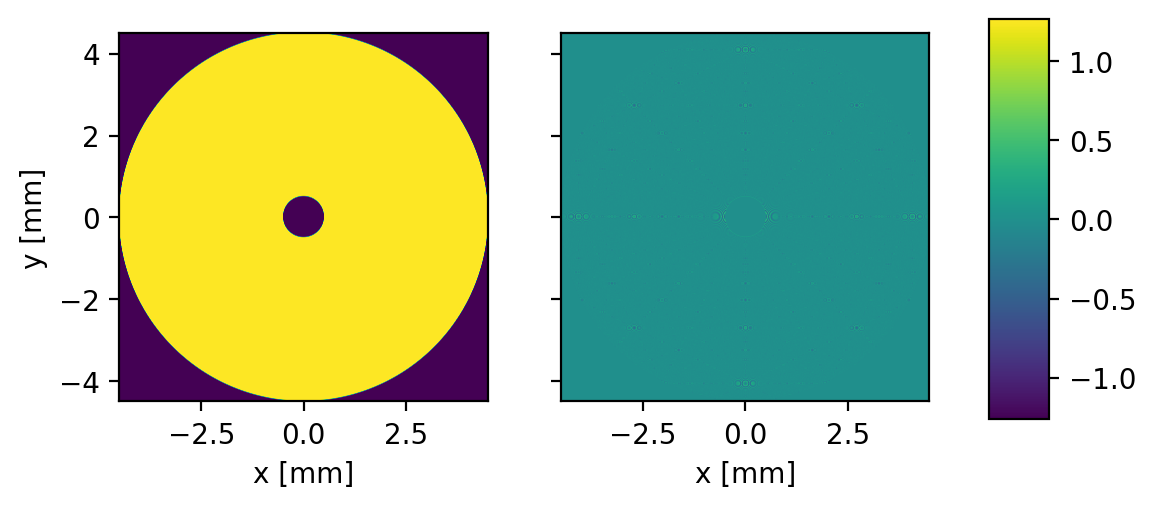

In [68]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True,dpi=200)
ax1,ax2 = axes
w = width/mm/2
ax1.imshow(abs(aper), extent=[-w,w,-w,w])
im = ax2.imshow(angle(mask), extent=[-w,w,-w,w])
for ax in axes:
    ax.set_aspect(1)
    ax.set_xlabel("x [mm]")
ax1.set_ylabel("y [mm]")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)

In [6]:
t0 = Scalar_mask_XY(x=x0, y=y0, wavelength=lmbda)
t0.u = mask # the complex mask

# apply the mask, calculate the new field
u1 = u0 * t0
time0 = time()
df = 0
print(f"defocus {df/um}um")
u2 = u1.RS(z=focus+df, new_field=True)
print(f"computed in {time() - time0}s")

defocus 0.0um
computed in 970.6803636550903s


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x1f9d65bb6a0>)

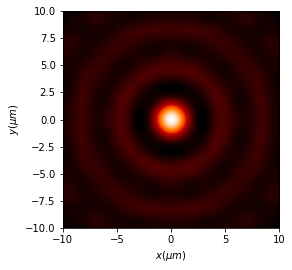

In [7]:
nw = 10 * um
uresamp = u2.cut_resample(
  x_limits=(-nw, nw),
  y_limits=(-nw, nw),
  num_points=[1024, 1024],
  new_field=True)
uresamp.draw(kind='intensity')

wrote data to parabolic_mir_dia9mm_roc10pt5_hole_dia_1mm_spot_vs_gaussian.csv


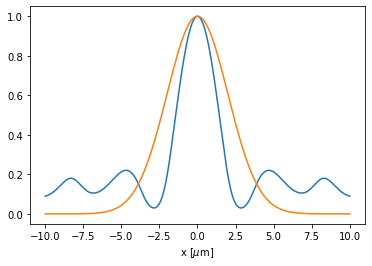

In [9]:
slicelen = len(uresamp.u[0,:])
slicepts = uresamp.u[slicelen//2,:]
xpts = linspace(-nw,nw,slicelen)
plt.plot(xpts, abs(slicepts)**2/max(abs(slicepts)**2))
plt.plot(xpts, exp(-2*(xpts/(4*um))**2))
plt.xlabel(r"x [$\mu$m]")

data = [xpts, abs(slicepts)**2/max(abs(slicepts)**2), exp(-2*(xpts/(4*um))**2)]
labels = ['xpts', 'focal intensity', 'w0=4 um Gaussian']

# fname = "parabolic_mir_dia9mm_roc10pt5_hole_dia_1mm_spot_vs_gaussian.csv"
# soln_to_csv(fname, data, labels, metastr=None)